## Poisson equation with constant coefficient
The Poisson equation on a unit disk with zero Dirichlet boundary condition can be written as $- \nabla \cdot (c\nabla  u) = 1$  in $\Omega$, $u=0$ on $\partial \Omega$ , where $\Omega$  is the unit disk. The exact solution when  is
$$
u(x,y)= \frac{1-x^2-y^2}{4}
$$


Here, objective is to compute the coefficient $c$ using PINN and we assume $c$ is scalar.

In [1]:
## Import the required modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

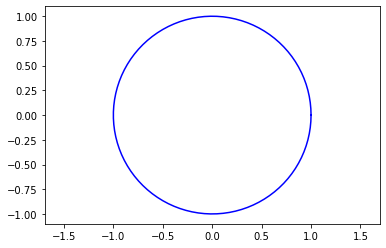

In [2]:
## Problem description
r = 1
theta = np.linspace(0, 2*np.pi, 100)
x = r*np.cos(theta)
y = r*np.sin(theta)
plt.plot(x, y, "-b", lw=1.5)
plt.axis("equal");

In [3]:
def generate_collocation_points(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)    
    xy = np.concatenate((x, y), axis=1)
    return xy

def generate_boundary_points(radius, num_samples):
    theta = np.linspace(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatenate((x, y), axis=1)
    return xy

def analytical_sol(xy):
    u = (1/4.0)*(1 - xy[:, 0]*xy[:,0] - xy[:, 1]* xy[:, 1])
    u = u.reshape(-1, 1)
    return u


def generate_validation_data(radius, num_samples):
    r = radius * np.sqrt(np.random.rand(num_samples, 1))
    theta = np.random.uniform(0, 2 * np.pi, num_samples)
    x = r * np.cos(theta).reshape(-1, 1)
    y = r * np.sin(theta).reshape(-1, 1)
    xy = np.concatentae((x, y), axis=1)
    return xy
    



In [9]:
class PINN(nn.Module):
    def __init__(self, input_size, num_neurons, output_size):
        super(PINN, self).__init__()
        self.c = nn.Parameter(torch.tensor(1.0))
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.activation_1 = nn.Tanh()
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.activation_2 = nn.Tanh()
        self.fc3 = nn.Linear(num_neurons, output_size)
        
    def get_parameter(self):
        return self.c
    

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_1(x)
        x = self.fc2(x)
        x = self.activation_2(x)
        x = self.fc3(x)
        return x
    
    

def net_f(model, xy_f):
    u = model(xy_f)
    grad_u = torch.autograd.grad(u, xy_f, grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
    u_xx = torch.autograd.grad(model.get_parameter() * grad_u[:, 0], xy_f, grad_outputs=torch.ones_like(grad_u[:, 0]),
                               create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(model.get_parameter()*grad_u[:, 1], xy_f, grad_outputs=torch.ones_like(grad_u[:, 1]),
                               create_graph=True)[0][:, 1]
    return u_xx + u_yy + 1.0

def net_d(model, x_d):
    u = model(x_d)
    return u

def loss_fn(model, xy_f, xy_d, u_d):
    f = net_f(model, xy_f)
    d = net_d(model, xy_d)
    loss_f = (f**2).mean() 
    loss_d = ((d - u_d)**2).mean()
    loss = loss_d + 0.01*loss_f
    return loss

    
    

In [10]:
if __name__=="__main__":
    r =1.0
    num_collocation_points = 1000
    num_boundary_points = 100
    num_data = 50
    
    # Initialize Collocation Points
    xy_f = torch.tensor(generate_collocation_points(r, num_collocation_points), requires_grad=True, 
                        dtype=torch.float32)
  
    
    # Initialize boundary points
    xy_b = torch.tensor(generate_boundary_points(r, num_boundary_points), dtype=torch.float32)
    u_b = torch.zeros((xy_b.size(0), 1), dtype=torch.float32)
    
    # Initialize data values
    xy_d = generate_collocation_points(r, num_data)
    u_d = analytical_sol(xy_d)
    xy_d = torch.tensor(xy_d, dtype=torch.float32)
    u_d = torch.tensor(u_d, dtype=torch.float32)
 
    # Concatenate boundary and interior data points
    xy_data = torch.concatenate((xy_b, xy_d), axis=0)
    u_data = torch.concatenate((u_b, u_d), axis=0)
    nIters = 1500
    d_in = 2
    num_neurons = 60
    d_out = 1
    lr = 1e-03
    model = PINN(d_in, num_neurons, d_out)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_history = []
    c_history = np.zeros(shape=(nIters, 1))
        
    # Start Training    
    for it in range(0, nIters):
        optimizer.zero_grad()
        loss = loss_fn(model, xy_f, xy_d, u_d)
        loss.backward()
        optimizer.step()
        if it % 1 == 0:
            c = model.get_parameter().detach().cpu().numpy()
            print(f"Epoch {it+1}/{nIters}, Loss: {loss:.8f} and c: {c}")
            c_history[it]= c
            #print(f"Type: {type(c)}")
            loss_history.append(loss.detach().cpu().numpy())

      


Epoch 1/1500, Loss: 0.03887026 and c: 0.9990000128746033
Epoch 2/1500, Loss: 0.02111608 and c: 0.9987173676490784
Epoch 3/1500, Loss: 0.01520782 and c: 0.9991441965103149
Epoch 4/1500, Loss: 0.01742603 and c: 0.9998184442520142
Epoch 5/1500, Loss: 0.02071767 and c: 1.0006073713302612
Epoch 6/1500, Loss: 0.02106353 and c: 1.0014643669128418
Epoch 7/1500, Loss: 0.01897287 and c: 1.0023653507232666
Epoch 8/1500, Loss: 0.01632800 and c: 1.0032939910888672
Epoch 9/1500, Loss: 0.01461580 and c: 1.0042369365692139
Epoch 10/1500, Loss: 0.01437700 and c: 1.005183219909668
Epoch 11/1500, Loss: 0.01520497 and c: 1.0061249732971191
Epoch 12/1500, Loss: 0.01618597 and c: 1.0070586204528809
Epoch 13/1500, Loss: 0.01655342 and c: 1.007985234260559
Epoch 14/1500, Loss: 0.01608687 and c: 1.008909821510315
Epoch 15/1500, Loss: 0.01506993 and c: 1.009839415550232
Epoch 16/1500, Loss: 0.01400916 and c: 1.0107810497283936
Epoch 17/1500, Loss: 0.01334260 and c: 1.0117404460906982
Epoch 18/1500, Loss: 0.0132

Epoch 152/1500, Loss: 0.00158478 and c: 1.1734917163848877
Epoch 153/1500, Loss: 0.00155986 and c: 1.1741783618927002
Epoch 154/1500, Loss: 0.00153624 and c: 1.1748487949371338
Epoch 155/1500, Loss: 0.00151385 and c: 1.175503134727478
Epoch 156/1500, Loss: 0.00149265 and c: 1.176141381263733
Epoch 157/1500, Loss: 0.00147260 and c: 1.1767635345458984
Epoch 158/1500, Loss: 0.00145364 and c: 1.1773695945739746
Epoch 159/1500, Loss: 0.00143571 and c: 1.1779597997665405
Epoch 160/1500, Loss: 0.00141875 and c: 1.1785341501235962
Epoch 161/1500, Loss: 0.00140270 and c: 1.1790928840637207
Epoch 162/1500, Loss: 0.00138752 and c: 1.1796361207962036
Epoch 163/1500, Loss: 0.00137313 and c: 1.1801639795303345
Epoch 164/1500, Loss: 0.00135948 and c: 1.1806766986846924
Epoch 165/1500, Loss: 0.00134651 and c: 1.1811745166778564
Epoch 166/1500, Loss: 0.00133417 and c: 1.1816577911376953
Epoch 167/1500, Loss: 0.00132240 and c: 1.1821266412734985
Epoch 168/1500, Loss: 0.00131115 and c: 1.1825814247131348

Epoch 305/1500, Loss: 0.00056703 and c: 1.2078555822372437
Epoch 306/1500, Loss: 0.00056357 and c: 1.2079277038574219
Epoch 307/1500, Loss: 0.00056013 and c: 1.2079976797103882
Epoch 308/1500, Loss: 0.00055671 and c: 1.2080655097961426
Epoch 309/1500, Loss: 0.00055330 and c: 1.2081313133239746
Epoch 310/1500, Loss: 0.00054992 and c: 1.2081950902938843
Epoch 311/1500, Loss: 0.00054654 and c: 1.2082568407058716
Epoch 312/1500, Loss: 0.00054319 and c: 1.2083165645599365
Epoch 313/1500, Loss: 0.00053985 and c: 1.2083743810653687
Epoch 314/1500, Loss: 0.00053653 and c: 1.2084301710128784
Epoch 315/1500, Loss: 0.00053322 and c: 1.2084840536117554
Epoch 316/1500, Loss: 0.00052993 and c: 1.208536148071289
Epoch 317/1500, Loss: 0.00052665 and c: 1.20858633518219
Epoch 318/1500, Loss: 0.00052339 and c: 1.2086347341537476
Epoch 319/1500, Loss: 0.00052014 and c: 1.208681344985962
Epoch 320/1500, Loss: 0.00051691 and c: 1.2087260484695435
Epoch 321/1500, Loss: 0.00051369 and c: 1.2087689638137817
E

Epoch 460/1500, Loss: 0.00018308 and c: 1.1981467008590698
Epoch 461/1500, Loss: 0.00018155 and c: 1.1979442834854126
Epoch 462/1500, Loss: 0.00018003 and c: 1.1977399587631226
Epoch 463/1500, Loss: 0.00017852 and c: 1.1975338459014893
Epoch 464/1500, Loss: 0.00017703 and c: 1.1973258256912231
Epoch 465/1500, Loss: 0.00017555 and c: 1.1971158981323242
Epoch 466/1500, Loss: 0.00017408 and c: 1.196904182434082
Epoch 467/1500, Loss: 0.00017263 and c: 1.196690559387207
Epoch 468/1500, Loss: 0.00017119 and c: 1.1964751482009888
Epoch 469/1500, Loss: 0.00016976 and c: 1.1962578296661377
Epoch 470/1500, Loss: 0.00016834 and c: 1.1960387229919434
Epoch 471/1500, Loss: 0.00016694 and c: 1.1958177089691162
Epoch 472/1500, Loss: 0.00016555 and c: 1.1955949068069458
Epoch 473/1500, Loss: 0.00016417 and c: 1.1953703165054321
Epoch 474/1500, Loss: 0.00016281 and c: 1.1951438188552856
Epoch 475/1500, Loss: 0.00016146 and c: 1.194915533065796
Epoch 476/1500, Loss: 0.00016012 and c: 1.194685459136963
E

Epoch 613/1500, Loss: 0.00006379 and c: 1.1507166624069214
Epoch 614/1500, Loss: 0.00006346 and c: 1.150345802307129
Epoch 615/1500, Loss: 0.00006313 and c: 1.1499748229980469
Epoch 616/1500, Loss: 0.00006280 and c: 1.1496037244796753
Epoch 617/1500, Loss: 0.00006248 and c: 1.1492325067520142
Epoch 618/1500, Loss: 0.00006215 and c: 1.1488611698150635
Epoch 619/1500, Loss: 0.00006183 and c: 1.1484897136688232
Epoch 620/1500, Loss: 0.00006151 and c: 1.148118257522583
Epoch 621/1500, Loss: 0.00006120 and c: 1.1477466821670532
Epoch 622/1500, Loss: 0.00006088 and c: 1.1473751068115234
Epoch 623/1500, Loss: 0.00006057 and c: 1.1470035314559937
Epoch 624/1500, Loss: 0.00006026 and c: 1.1466318368911743
Epoch 625/1500, Loss: 0.00005995 and c: 1.146260142326355
Epoch 626/1500, Loss: 0.00005965 and c: 1.1458884477615356
Epoch 627/1500, Loss: 0.00005934 and c: 1.1455167531967163
Epoch 628/1500, Loss: 0.00005904 and c: 1.145145058631897
Epoch 629/1500, Loss: 0.00005874 and c: 1.1447733640670776
E

Epoch 766/1500, Loss: 0.00002982 and c: 1.0971224308013916
Epoch 767/1500, Loss: 0.00002967 and c: 1.0968124866485596
Epoch 768/1500, Loss: 0.00002953 and c: 1.0965031385421753
Epoch 769/1500, Loss: 0.00002939 and c: 1.0961945056915283
Epoch 770/1500, Loss: 0.00002924 and c: 1.0958865880966187
Epoch 771/1500, Loss: 0.00002910 and c: 1.0955791473388672
Epoch 772/1500, Loss: 0.00002897 and c: 1.0952725410461426
Epoch 773/1500, Loss: 0.00002884 and c: 1.0949664115905762
Epoch 774/1500, Loss: 0.00002873 and c: 1.0946612358093262
Epoch 775/1500, Loss: 0.00002864 and c: 1.0943562984466553
Epoch 776/1500, Loss: 0.00002862 and c: 1.0940525531768799
Epoch 777/1500, Loss: 0.00002870 and c: 1.0937488079071045
Epoch 778/1500, Loss: 0.00002901 and c: 1.0934467315673828
Epoch 779/1500, Loss: 0.00002973 and c: 1.0931440591812134
Epoch 780/1500, Loss: 0.00003114 and c: 1.092843770980835
Epoch 781/1500, Loss: 0.00003336 and c: 1.0925421714782715
Epoch 782/1500, Loss: 0.00003605 and c: 1.092243790626525

Epoch 920/1500, Loss: 0.00002246 and c: 1.057847023010254
Epoch 921/1500, Loss: 0.00001664 and c: 1.0576475858688354
Epoch 922/1500, Loss: 0.00001469 and c: 1.057449221611023
Epoch 923/1500, Loss: 0.00001680 and c: 1.057252287864685
Epoch 924/1500, Loss: 0.00002029 and c: 1.0570554733276367
Epoch 925/1500, Loss: 0.00002203 and c: 1.0568599700927734
Epoch 926/1500, Loss: 0.00002053 and c: 1.056664228439331
Epoch 927/1500, Loss: 0.00001717 and c: 1.056469202041626
Epoch 928/1500, Loss: 0.00001464 and c: 1.056274175643921
Epoch 929/1500, Loss: 0.00001458 and c: 1.0560791492462158
Epoch 930/1500, Loss: 0.00001630 and c: 1.0558847188949585
Epoch 931/1500, Loss: 0.00001781 and c: 1.055690050125122
Epoch 932/1500, Loss: 0.00001767 and c: 1.055496096611023
Epoch 933/1500, Loss: 0.00001607 and c: 1.0553022623062134
Epoch 934/1500, Loss: 0.00001442 and c: 1.0551090240478516
Epoch 935/1500, Loss: 0.00001396 and c: 1.054916501045227
Epoch 936/1500, Loss: 0.00001467 and c: 1.0547243356704712
Epoch 

Epoch 1076/1500, Loss: 0.00000847 and c: 1.0334521532058716
Epoch 1077/1500, Loss: 0.00000869 and c: 1.0333350896835327
Epoch 1078/1500, Loss: 0.00000910 and c: 1.033218264579773
Epoch 1079/1500, Loss: 0.00000930 and c: 1.0331016778945923
Epoch 1080/1500, Loss: 0.00000913 and c: 1.0329854488372803
Epoch 1081/1500, Loss: 0.00000873 and c: 1.032869577407837
Epoch 1082/1500, Loss: 0.00000839 and c: 1.0327541828155518
Epoch 1083/1500, Loss: 0.00000831 and c: 1.0326392650604248
Epoch 1084/1500, Loss: 0.00000845 and c: 1.032524824142456
Epoch 1085/1500, Loss: 0.00000864 and c: 1.032410979270935
Epoch 1086/1500, Loss: 0.00000869 and c: 1.0322976112365723
Epoch 1087/1500, Loss: 0.00000857 and c: 1.0321848392486572
Epoch 1088/1500, Loss: 0.00000836 and c: 1.0320725440979004
Epoch 1089/1500, Loss: 0.00000819 and c: 1.0319607257843018
Epoch 1090/1500, Loss: 0.00000814 and c: 1.0318493843078613
Epoch 1091/1500, Loss: 0.00000819 and c: 1.0317384004592896
Epoch 1092/1500, Loss: 0.00000827 and c: 1.0

Epoch 1228/1500, Loss: 0.00000582 and c: 1.020094394683838
Epoch 1229/1500, Loss: 0.00000582 and c: 1.0200297832489014
Epoch 1230/1500, Loss: 0.00000592 and c: 1.019965410232544
Epoch 1231/1500, Loss: 0.00000602 and c: 1.0199013948440552
Epoch 1232/1500, Loss: 0.00000605 and c: 1.019837498664856
Epoch 1233/1500, Loss: 0.00000598 and c: 1.0197738409042358
Epoch 1234/1500, Loss: 0.00000587 and c: 1.0197104215621948
Epoch 1235/1500, Loss: 0.00000576 and c: 1.0196471214294434
Epoch 1236/1500, Loss: 0.00000571 and c: 1.019584059715271
Epoch 1237/1500, Loss: 0.00000572 and c: 1.0195211172103882
Epoch 1238/1500, Loss: 0.00000576 and c: 1.0194584131240845
Epoch 1239/1500, Loss: 0.00000580 and c: 1.0193959474563599
Epoch 1240/1500, Loss: 0.00000580 and c: 1.019333839416504
Epoch 1241/1500, Loss: 0.00000577 and c: 1.019271969795227
Epoch 1242/1500, Loss: 0.00000571 and c: 1.0192104578018188
Epoch 1243/1500, Loss: 0.00000566 and c: 1.0191491842269897
Epoch 1244/1500, Loss: 0.00000562 and c: 1.019

Epoch 1379/1500, Loss: 0.00000456 and c: 1.012959361076355
Epoch 1380/1500, Loss: 0.00000463 and c: 1.0129238367080688
Epoch 1381/1500, Loss: 0.00000465 and c: 1.0128883123397827
Epoch 1382/1500, Loss: 0.00000462 and c: 1.0128530263900757
Epoch 1383/1500, Loss: 0.00000456 and c: 1.0128178596496582
Epoch 1384/1500, Loss: 0.00000449 and c: 1.0127828121185303
Epoch 1385/1500, Loss: 0.00000444 and c: 1.0127480030059814
Epoch 1386/1500, Loss: 0.00000444 and c: 1.0127134323120117
Epoch 1387/1500, Loss: 0.00000446 and c: 1.012679100036621
Epoch 1388/1500, Loss: 0.00000448 and c: 1.01264488697052
Epoch 1389/1500, Loss: 0.00000450 and c: 1.0126110315322876
Epoch 1390/1500, Loss: 0.00000449 and c: 1.0125772953033447
Epoch 1391/1500, Loss: 0.00000446 and c: 1.012543797492981
Epoch 1392/1500, Loss: 0.00000443 and c: 1.0125105381011963
Epoch 1393/1500, Loss: 0.00000440 and c: 1.0124773979187012
Epoch 1394/1500, Loss: 0.00000438 and c: 1.0124444961547852
Epoch 1395/1500, Loss: 0.00000438 and c: 1.01

In [11]:
## Postprocess the output
def prediction(model, xy):
    u_val =  model(xy)
    return u_val.detach().cpu().numpy()

def save_model(trained_model):
    torch.save(trained_model, "model.pth")
    pass

def load_model(model_name):
    torch.load(model_name, "model.pth")

Relative l2 error is: 2.4898%


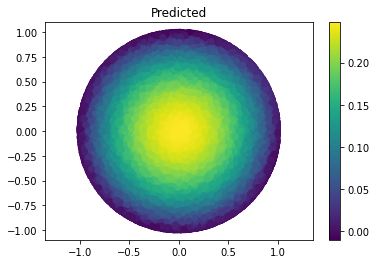

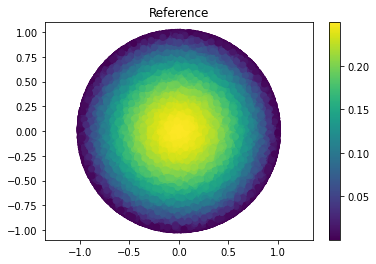

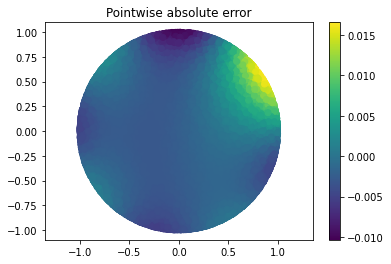

In [12]:
#Validation datapoints
num_val_dat = 100000
xy_val = generate_collocation_points(r, num_val_dat)
u_true = analytical_sol(xy_val)

xy_val = torch.tensor(xy_val, dtype=torch.float32)

u_pred = prediction(model, xy_val)

l2_error = np.linalg.norm(u_pred - u_true)/np.linalg.norm(u_true)

print(f"Relative l2 error is: {l2_error*100:0.4f}%")

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_pred)
plt.title("Predicted")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_true)
plt.title("Reference")
plt.axis("Equal")
plt.colorbar()
plt.show()

plt.scatter(xy_val[:, 0], xy_val[:, 1], c=u_pred - u_true)
plt.title("Pointwise absolute error")
plt.axis("Equal")
plt.colorbar()
plt.show()



    

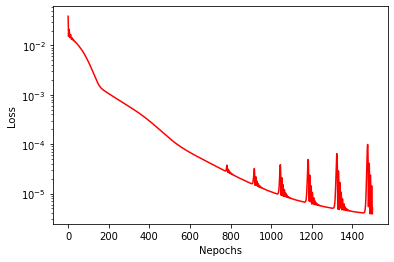

array([[0.99900001],
       [0.99871737],
       [0.9991442 ],
       ...,
       [1.009884  ],
       [1.00986338],
       [1.00984275]])

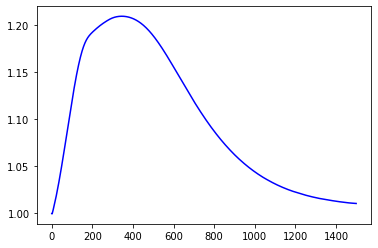

In [13]:
# Plot of convergence of loss and parameters
it = np.arange(0, nIters)
plt.semilogy(it, loss_history, "-r")
plt.xlabel("Nepochs")
plt.ylabel("Loss")
plt.show()

plt.plot(it, c_history, "-b")
c_history